In [55]:
import random

import torch
import torch.nn as nn

from torch.utils.data import (Dataset,
                              DataLoader,
                              random_split)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import mlflow

In [56]:
seed = 0xCAFE

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(mode=True)

generator = torch.Generator()
generator.manual_seed(seed)

def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
class TrainDataset(Dataset):

    def __init__(self, path: str, transform = None):
        self.X, self.y = TrainDataset.get_input_and_targets(path=path)
        self.transform = transform

    def __getitem__(self, idx) -> np.ndarray:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.X[idx], self.y[idx])

        if self.transform:
            sample = (self.transform(sample[0]), self.transform(sample[1]))

        return sample

    def __len__(self) -> int:
        return len(self.X)

    @staticmethod
    def get_input_and_targets(path: str) -> tuple[np.ndarray, np.ndarray]:
        df = pd.read_csv(path)

        X = (df.iloc[:, 1:].to_numpy() / 255.0).astype(np.float32)

        y = df['label']

        return X, y

In [59]:
class TestDataset(Dataset):

    def __init__(self, path: str, transform = None):
        self.X = TestDataset.get_input(path=path)
        self.transform = transform

    def __getitem__(self, idx) -> np.ndarray:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.X[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self) -> int:
        return len(self.X)

    @staticmethod
    def get_input(path: str) -> tuple[np.ndarray, np.ndarray]:
        df = pd.read_csv(path)

        X = df.to_numpy(dtype=np.float32)

        return X

In [60]:
train_subset, validation_subset = random_split(TrainDataset(path='.DATA/MNIST/train.csv'),
                                               lengths=[ 0.8, 0.2 ],
                                               generator=generator)

In [61]:
train_dataloader = DataLoader(train_subset,
                              batch_size=64,
                              shuffle=True,
                              generator=generator,
                              worker_init_fn=seed_worker)

In [62]:
eval_dataloader = DataLoader(validation_subset,
                             batch_size=64,
                             generator=generator,
                             worker_init_fn=seed_worker)

In [63]:
test_dataloader = DataLoader(TestDataset(path='.DATA/MNIST/test.csv'),
                             batch_size=64,
                             generator=generator,
                             worker_init_fn=seed_worker)

In [64]:
def train(model: nn.Module, criterion: nn.Module, optmizer: torch.optim.Optimizer, dataloader: DataLoader):
    model.train()

    progress_bar = tqdm.tqdm(enumerate(dataloader), desc='Training', leave=True)

    for batch, (X, y) in progress_bar:
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.to(device)

        optmizer.zero_grad()

        y_hat: torch.Tensor = model(X)

        loss: torch.Tensor = criterion(y_hat, y)

        loss.backward()

        optmizer.step()

        if batch % 100 == 0:
            progress_bar.set_description(desc=f'Loss: {loss:.3f} | Training')

        mlflow.log_metric('loss', loss, batch)

In [65]:
def test(model: nn.Module, dataloader: DataLoader):
    model.eval()

    correct = int(0)

    for X, y in tqdm.tqdm(dataloader, desc='Testing', leave=True):
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.to(device)

        y_hat: torch.Tensor = model(X)

        correct += (y_hat.argmax(1) == y).sum().item()

    accuracy = (correct / len(dataloader.dataset)) * 100.0

    mlflow.log_metric('accuracy', accuracy)

In [66]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [67]:
exp = mlflow.set_experiment(experiment_name='Kaggle: Digit Recognizer')

2023/11/11 20:47:23 INFO mlflow.tracking.fluent: Experiment with name 'Kaggle: Digit Recognizer' does not exist. Creating a new experiment.


In [68]:
active_run = mlflow.start_run(run_name='LinearClassifier')

In [69]:
model = nn.Linear(784, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [70]:
train(model=model, optmizer=optimizer, criterion=nn.functional.cross_entropy, dataloader=train_dataloader)

Loss: 0.435 | Training: : 525it [00:04, 105.01it/s]


In [71]:
test(model=model, dataloader=eval_dataloader)

Testing: 100%|██████████| 132/132 [00:00<00:00, 381.32it/s]


In [72]:
_ = torch.set_grad_enabled(False)

In [73]:
def get_signature(model: nn.Module, test_dataloader: DataLoader):
    with torch.no_grad():
        X: torch.Tensor = next(iter(test_dataloader))

        signature = mlflow.models.infer_signature(X.numpy(), model(X).numpy())

        return signature

In [74]:
_ = mlflow.pytorch.log_model(model, artifact_path='LinearClassifierModel', signature=get_signature(model, test_dataloader))

2023/11/11 20:47:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/11/11 20:47:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/home/hott/.pyenv/versions/3.11.4/envs/kdl/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to 

In [75]:
submission_path = '.DATA/MNIST/submission.csv'

In [76]:
with open(submission_path, mode='w') as f:
    print('ImageId', 'Label', sep=',', file=f)

    for batch, X in enumerate(test_dataloader, 0):
        X: torch.Tensor = X.to(device)

        logits: torch.Tensor = model(X)

        for id, y_hat in enumerate(logits.argmax(dim=1), 1):
            id = id + (batch * test_dataloader.batch_size)

            print(id, y_hat.item(), sep=',', file=f)

In [77]:
mlflow.log_artifact(submission_path)

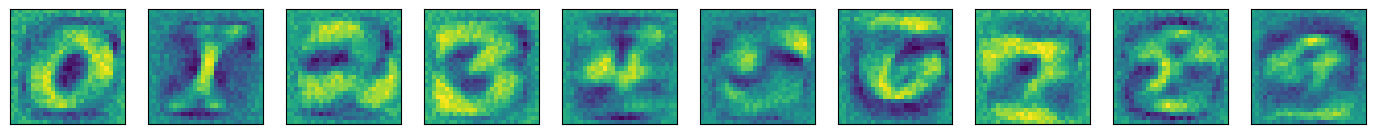

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(17.5, 2.5))

for i in range(10):
    w: torch.Tensor = nn.functional.normalize(model.weight[i], dim=0).reshape(28, 28)

    ax = axes[i]

    ax.tick_params(axis='both', which='both',
                    bottom=False, top=False,
                    left=False, right=False,
                    labelbottom=False, labeltop=False,
                    labelleft=False, labelright=False)

    ax.imshow(w)

mlflow.log_figure(figure=fig, artifact_file='weights.png')

In [79]:
mlflow.end_run()

In [80]:
_ = torch.set_grad_enabled(True)